# Model Building

In [55]:
# Basic Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from src.utils import split_text_data, build_logistic_pipeline

## Load + Split Dataset

Separate training, validation, and test sets to enable hyperparameter tuning without test set leakage.

In [45]:
df_subset = pd.read_csv("./data/yelp_reviews_subset.csv")
df_subset.head()

,review_id,stars,text,date,label
0,igUar2sMmvX7Ps1AbvQXgg,1,This is the worst Walmart ever conceived by hu...,2020-07-07 22:59:20,0
1,peB3hSTWXgpsc2SCaBEPtA,5,I've always loved Outback and the fact that th...,2020-06-05 20:58:29,1
2,wrLFWRBu_JkD6CW5XpLj5w,5,LOVE THIS PLACE!! Such amazing ice cream at a ...,2020-05-13 02:10:17,1
3,_Mgbav5Q7LD1FZfIvueQXw,5,Took both my pups for a way ovetdue grooming. ...,2020-05-11 01:18:16,1
4,j0dc6B6xEXTp_zYMuJ3ysQ,1,"i went to get a chicken sandwich, and being al...",2020-05-04 01:57:38,0


In [46]:
X = df_subset["text"]
y = df_subset["label"]

X_train, X_valid, X_test, y_train, y_valid, y_test = split_text_data(
    X,
    y,
    test_size=0.2,
    val_size=0.2,
    random_state=42
)

print("Train:", len(X_train))
print("Validation:", len(X_valid))
print("Test:", len(X_test))

Train: 12800
Validation: 3200
Test: 4000


## Validation-based C tuning (GridSearchCV)

Tune the regularization strength of logistic regression using validation performance (ROC-AUC).

In [47]:
pipeline = build_logistic_pipeline()

In [48]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters: {'clf__C': 10}


## Validation performance check

Confirm that the tuned model generalizes well before evaluating on the test set.

In [49]:
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Validation ROC-AUC:", roc_auc_score(y_valid, y_valid_proba))

Validation Accuracy: 0.9103125
Validation ROC-AUC: 0.96240967353962


## Evaluation on test set

In [50]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_test_pred)
roc = roc_auc_score(y_test, y_test_proba)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC:  {roc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.904
ROC-AUC:  0.958

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1098
           1       0.94      0.92      0.93      2902

    accuracy                           0.90      4000
   macro avg       0.88      0.89      0.88      4000
weighted avg       0.91      0.90      0.90      4000



## Confusion matrix visualization

Visualize the types of classification errors made by the model.

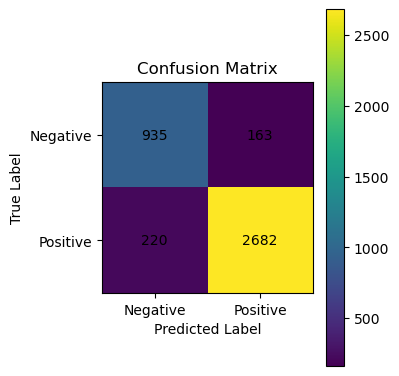

In [56]:
plt.figure(figsize=(4, 4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()

plt.savefig("outputs/confusion_matrix.png", bbox_inches="tight", dpi=300)

plt.show()

## Interpretability: top positive / negative tokens

Interpret the learned model by examining which words most strongly influence predictions.

In [52]:
tfidf = best_model.named_steps["tfidf"]
clf = best_model.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

top_positive = pd.DataFrame({
    "token": feature_names[top_pos_idx],
    "coefficient": coefs[top_pos_idx]
})

top_negative = pd.DataFrame({
    "token": feature_names[top_neg_idx],
    "coefficient": coefs[top_neg_idx]
})

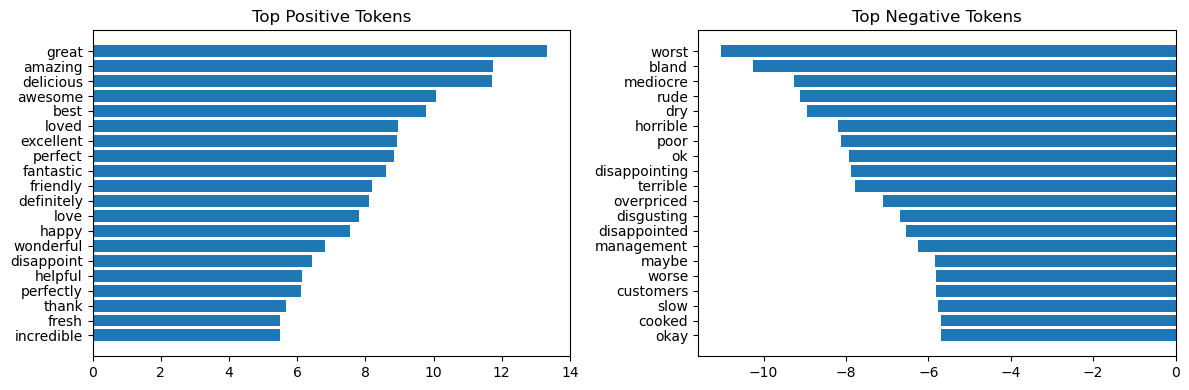

In [57]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.barh(top_positive["token"], top_positive["coefficient"])
plt.title("Top Positive Tokens")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_negative["token"], top_negative["coefficient"])
plt.title("Top Negative Tokens")
plt.gca().invert_yaxis()

plt.tight_layout()

plt.savefig("outputs/top_positive_negative_tokens.png", bbox_inches="tight", dpi=300)

plt.show()

## Error Analysis

Qualitatively inspect misclassified examples and understand model limitations.

In [54]:
error_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_test_pred
})

misclassified = error_df[error_df["true_label"] != error_df["pred_label"]]

print("False Positives:")
display(misclassified[(misclassified.true_label == 0) & (misclassified.pred_label == 1)].head(3))

print("\nFalse Negatives:")
display(misclassified[(misclassified.true_label == 1) & (misclassified.pred_label == 0)].head(3))

False Positives:


,text,true_label,pred_label
6821,Still. Not. Good. Great atmosphere for drinks ...,0,1
10879,Cute interior. I got the bravo mixed boba milk...,0,1
1142,I am cool with the appeal of little Portland i...,0,1



False Negatives:


,text,true_label,pred_label
6043,Went in to get docs bound and to pick up misc ...,1,0
19652,"WE'RE TAKING OUR USUAL SUNDAY DRIVE. SUDDENLY,...",1,0
6762,Friendly owner/seamstress and her dog are the ...,1,0
